In [17]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split


import scikitplot as skplt

import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [13]:
df= pd.read_csv('./data/consensus_dataset.csv').drop(columns = 'Unnamed: 0')
df

,ad,consensus
0,we are fighting against a 1 million smear camp...,1
1,big thanks to our freenewyork partners and th...,0
2,we need your help to hit our fundraising goal ...,1
3,should sacramento stop loyalty programs for ho...,0
4,urgent we just launched ads against mitch mcco...,1
...,...,...
13271,let’s declare war on israel from the title of ...,1
13272,some legislators tell us “not in my backyard” ...,1
13273,youre invited to a live debate on question ho...,0
13274,no one should be left behind when it comes to ...,0


In [18]:
# build test and training datasets 
norm_train, norm_test, y_train, y_test= train_test_split( df['ad'], df['consensus'], test_size =0.2, random_state = 42)

In [20]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('carecomgozbaboon', 33564), ('<PAD>', 0), 1)

In [21]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [22]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((10620, 1000), (2656, 1000))

In [23]:
from tensorflow.keras.layers import Layer, InputSpec
from keras import backend as K


class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
            Attention Layer sourced from : https://github.com/lzfelix/keras_attention/blob/master/attention/layers.py

            Implementation based in the work of Yang et al. "Hierarchical Attention Networks for Document Classification". 
            This implementation also allows changing the common tanh activation function used on the attention layer, as Chen
            et al. "A Thorough Examination of the CNN/Daily Mail Reading Comprehension Task"
            point that removing this component can be beneficial to the model. Supports
            masking.
    
            The mathematical formulation of the model is as follows:
              ```
              u = f(W * h + b),
              a_i = softmax(u_i^T * u_s),
              v_i = \sigma_i a_i * h_i.
              ```
    
            # Arguments
                  activation: The activation function f used by the layer (see
                      [activations](../activations.md)). By default tanh is used, another common
                      option is "linear".
                  use_bias: Boolean, whether the layer uses a bias vector.
                  initializer: Initializer for the `kernel` and `context` matrices
                      (see [initializers](../initializers.md)).
                  return_attention: If True, instead of returning the sequence descriptor, this
                      layer will return the computed attention coefficients for each of the
                      sequence timesteps. See Output section for details.
                  W_regularizer: Regularizer function applied to the `kernel` weights matrix
                      (see [regularizer](../regularizers.md)).
                  u_regularizer: Regularizer function applied to the `context` weights matrix
                      (see [regularizer](../regularizers.md)).
                  b_regularizer: Regularizer function applied to the bias vector
                      (see [regularizer](../regularizers.md)).
                  W_constraint: Constraint function applied to the `kernel` weights matrix
                      (see [constraints](../constraints.md)).
                  u_constraint: Constraint function applied to the `contextl` weights matrix
                      (see [constraints](../constraints.md)).
                  b_constraint: Constraint function applied to the bias vector
                      (see [constraints](../constraints.md)).
          # Input shape
                  nD tensor with shape: `(batch_size, ..., timesteps, input_dim)`.
                  The most common situation would be a 3D input with shape
                  `(batch_size, timesteps, input_dim)`.
          # Outuput shape
                  The sequence descriptor with shape `(batch_size, ..., timestamps)`. If
                  `return_attention` is True, this layer will return the `alpha_i` weights
                  for each timestep, and consequently its output shape will be different, namely:
                  `(batch_size, ..., timesteps)`. 
        """
        
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape= (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [24]:
def create_model(vocab_size, embedding_dim, max_sequence_length, gru_dim,dropout = 0.2):
  '''
    Create a Bidirectional GRU used for binary text classification task
    Arguments : 
      vocab_size: vocabulary size 
      embedding_dim: embedding dimensions for the document vector representation 
      max_sequence_length: input sequence length for each document 
      gru_dim: number of neurones in the GRU layers
      dropout : dropout rate used for Dropout regularization layers to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - Input layer to instantiate a tensor using the input preprocessed data
            - Embedding layer to represent each document with a context vector
            - Biderectional GRU (takes into consideration bidrectional context)
            - A custom attention layer that takes **all** of the output of the GRU ( not the last hidden state only)
            - Dense layer 
            - Dropout layer to minimize overfitting
            - A Dense layer 
            - Dropout 
            - An output layer to get the label of the class 
  '''
  model = Sequential([
      layers.Input(shape=(max_sequence_length,)),
      layers.Embedding(vocab_size, embedding_dim, trainable=True),
      layers.Bidirectional(layers.GRU(gru_dim, return_sequences=True)),
      AttentionLayer(max_sequence_length),
      layers.Dense(gru_dim*2, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(gru_dim, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [25]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
GRU_DIM = 128 # units in GRU layers 
VOCAB_SIZE = len(t.word_index)

# Create the model
model = create_model(vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, max_sequence_length = MAX_SEQUENCE_LENGTH, gru_dim = GRU_DIM)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         4296320   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 256)        198144    
 l)                                                              
                                                                 
 attention_layer (AttentionL  (None, 256)              1256      
 ayer)                                                           
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [26]:
# model training 
batch_size = 32
model.fit(X_train, y_train, epochs= 5, batch_size=batch_size, 
          shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
266/266 [==============================] - 95s 318ms/step - loss: 0.2643 - accuracy: 0.8588 - val_loss: 0.0218 - val_accuracy: 0.9944
Epoch 2/5
266/266 [==============================] - 84s 316ms/step - loss: 0.0185 - accuracy: 0.9956 - val_loss: 0.0168 - val_accuracy: 0.9967
Epoch 3/5
266/266 [==============================] - 82s 309ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0206 - val_accuracy: 0.9958
Epoch 4/5
266/266 [==============================] - 82s 310ms/step - loss: 3.9195e-05 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9953
Epoch 5/5
266/266 [==============================] - 83s 310ms/step - loss: 9.1336e-06 - accuracy: 1.0000 - val_loss: 0.0271 - val_accuracy: 0.9953


83/83 [==============================] - 12s 129ms/step - loss: 0.0105 - accuracy: 0.9985
Accuracy: 99.85%
83/83 [==============================] - 10s 104ms/step
              precision    recall  f1-score   support

no consensus       1.00      1.00      1.00      1415
   consensus       1.00      1.00      1.00      1241

    accuracy                           1.00      2656
   macro avg       1.00      1.00      1.00      2656
weighted avg       1.00      1.00      1.00      2656

confusion matrix:
[[1413    2]
 [   2 1239]]



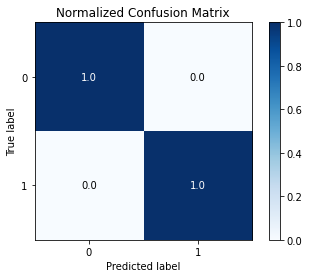

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# get model predictions 
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]


print(metrics.classification_report(y_test, predictions, target_names=['no consensus', 'consensus']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [28]:
df_val = pd.read_csv('./data/sample_consensus.csv')
df_val

,Unnamed: 0,ad,consensus
0,0,virtually everyone knows america has a big ill...,1
1,1,everyone knows smoking causes cancer but did y...,1
2,2,virtually everyone knows america has a big ill...,1
3,3,everyone knows michigan auto insurance is the ...,1
4,4,canadians from every region have shared with m...,1
5,5,voters want free and fair elections when im go...,1
6,6,massive crowds last evening for the meeting on...,1
7,7,several questions have come my way since the a...,0
8,8,brad recently stopped by to talk to henry hint...,0
9,9,british chickens are typically fed on soya fro...,0


1/1 [==============================] - 0s 159ms/step - loss: 4.5133 - accuracy: 0.7143
Accuracy: 71.43%
confusion matrix:
[[3 2]
 [2 7]]



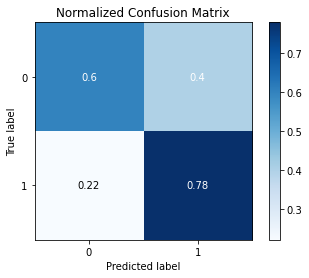

              precision    recall  f1-score   support

no consensus       0.60      0.60      0.60         5
   consensus       0.78      0.78      0.78         9

    accuracy                           0.71        14
   macro avg       0.69      0.69      0.69        14
weighted avg       0.71      0.71      0.71        14



In [30]:
norm_ = df_val['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

scores = model.evaluate(padded_, df_val['consensus'], verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

val_ = t.texts_to_sequences(norm_)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(val_, maxlen=MAX_SEQUENCE_LENGTH)
pred_ =  model.predict(padded_val)
df_val['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

print("confusion matrix:")
print(metrics.confusion_matrix(df_val['consensus'], df_val['predicted']  ))
print()

skplt.metrics.plot_confusion_matrix(df_val['consensus'], df_val['predicted'] , normalize=True)
plt.show()

print(metrics.classification_report(df_val['consensus'], df_val['predicted'] , target_names=[ 'no consensus', 'consensus']))